In [33]:
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
import re
from konlpy.tag import Kkma
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import sklearn
import pickle as pickle


In [5]:
pred = pd.read_csv('../code/prediction/dev_train_half_arg.csv')
labels = pd.read_csv('../data/dataset/train/dev_no_half_arg_equal.csv')
pred.head()

,id,pred_label,probs
0,25543,org:top_members/employees,"[4.930320938001387e-05, 0.9995700716972351, 1...."
1,14789,per:product,"[0.006643981672823429, 0.0002634026750456542, ..."
2,7185,per:spouse,"[0.001276473281905055, 9.156020678346977e-05, ..."
3,12313,per:siblings,"[0.0005542198196053505, 0.0037530353292822838,..."
4,31372,per:origin,"[0.00023139237600844353, 0.0006354803335852921..."


In [7]:
labels.head()

,Unnamed: 0,id,sentence,subject_entity,object_entity,label,source
0,25543,25543,는 지난 16일 한국철도공사를 방문해 손병석 사장에게 전라선 KTX 증편과 동력분산...,"{'word': '한국철도공사', 'start_idx': 9, 'end_idx': ...","{'word': '손병석', 'start_idx': 21, 'end_idx': 23...",org:top_members/employees,wikitree
1,14789,14789,"프레디 머큐리가 작곡한 곡들로 〈Bohemian Rhapsody〉, 〈We Are ...","{'word': '프레디 머큐리', 'start_idx': 0, 'end_idx':...","{'word': 'Killer Queen', 'start_idx': 136, 'en...",per:product,wikipedia
2,7185,7185,"지난 4일 방송된 SBS '동상이몽-너는 내 운명'에서는 최수종, 하희라 씨 부부가...","{'word': '최수종', 'start_idx': 32, 'end_idx': 34...","{'word': '하희라', 'start_idx': 37, 'end_idx': 39...",per:spouse,wikitree
3,12313,12313,"이날 이찬혁·이수현 씨 남매는 군대로 인해 떨어진 기간 동안 느꼈던 점, 목표 등에...","{'word': '이찬혁', 'start_idx': 3, 'end_idx': 5, ...","{'word': '이수현', 'start_idx': 7, 'end_idx': 9, ...",per:siblings,wikitree
4,31372,31372,프란츠 카프카는 오스트리아-헝가리 제국의 유대계 소설가이다.,"{'word': '카프카', 'start_idx': 4, 'end_idx': 6, ...","{'word': '오스트리아-헝가리 제국', 'start_idx': 9, 'end_...",per:origin,wikipedia


In [60]:


def label_to_num(label):
  num_label = []
  with open('../code/dict_label_to_num.pkl', 'rb') as f:
    dict_label_to_num = pickle.load(f)
  for v in label:
    num_label.append(dict_label_to_num[v])
  
  return num_label

In [63]:
compare = pd.concat([labels[['id','label']],pred.pred_label],axis=1)
compare['label'] = label_to_num(compare.label.values)
compare['pred_label'] = label_to_num(compare.pred_label.values)
compare.head()


,id,label,pred_label
0,25543,1,1
1,14789,8,8
2,7185,17,17
3,12313,16,16
4,31372,15,15


In [69]:
compare[compare.label==compare.pred_label].shape, compare[compare.label!=compare.pred_label].shape

((499, 3), (101, 3))

<Axes: xlabel='label', ylabel='pred_label'>

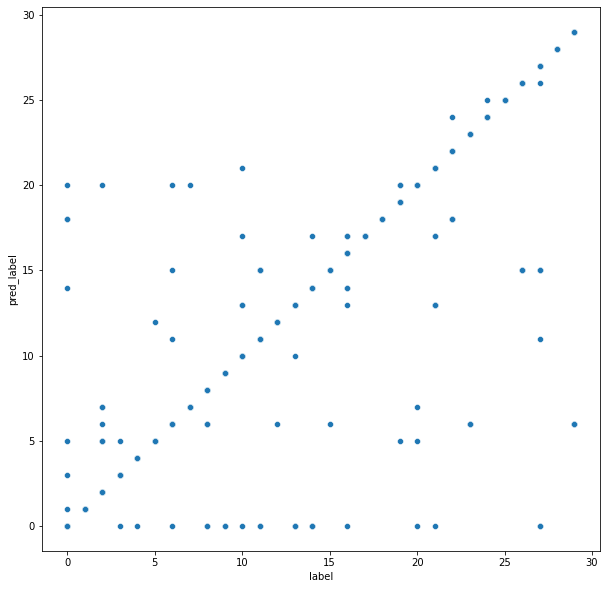

In [66]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=compare.label, y= compare.pred_label)
# plt.xticks(rotation=90)

<Axes: xlabel='label'>

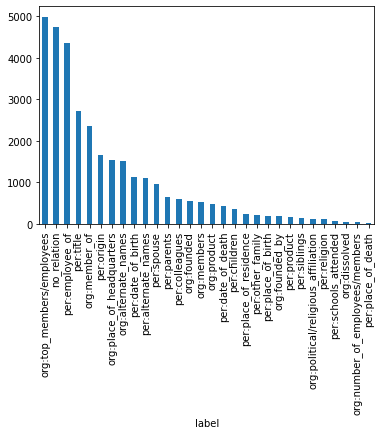

In [76]:
train_data = pd.read_csv('../data/dataset/train/train_no_half_arg_equal.csv')


<Axes: xlabel='label'>

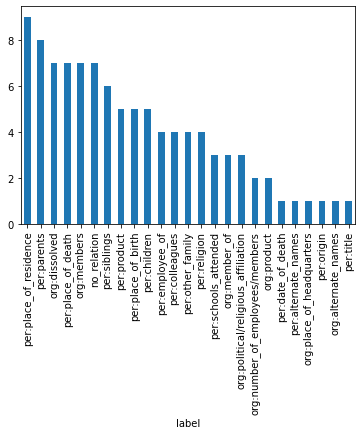

In [71]:
compare = pd.concat([labels[['id','label']],pred.pred_label],axis=1)

compare[compare.label!=compare.pred_label]['label'].value_counts().plot(kind='bar')

In [93]:
count_train = pd.concat([train_data['label'].value_counts()/250,compare[compare.label!=compare.pred_label]['label'].value_counts(),
                         compare[compare.label!=compare.pred_label]['pred_label'].value_counts(),compare[compare.label==compare.pred_label]['pred_label'].value_counts()],axis=1)
count_train.columns=['train','val_label','val_pred','correct']
count_train.head()


,train,val_label,val_pred,correct
org:top_members/employees,19.960,NaN,1.0,20
no_relation,18.980,7.0,21.0,13
per:employee_of,17.456,4.0,13.0,16
per:title,10.920,1.0,NaN,19
org:member_of,9.460,3.0,6.0,17


<Figure size 7200x7200 with 0 Axes>

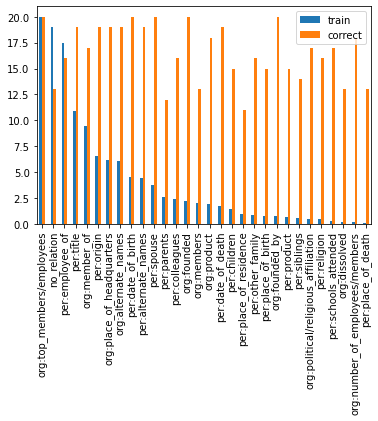

<Figure size 7200x7200 with 0 Axes>

In [96]:
count_train[['train','correct']].plot(kind='bar')

<Axes: >

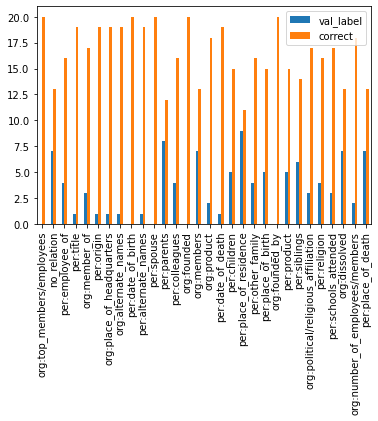

In [102]:
count_train[['val_label','correct']].plot(kind='bar')


<Axes: >

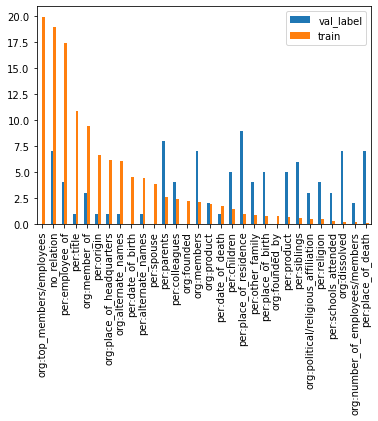

In [103]:
count_train[['val_label','train']].plot(kind='bar')


<Axes: xlabel='label'>

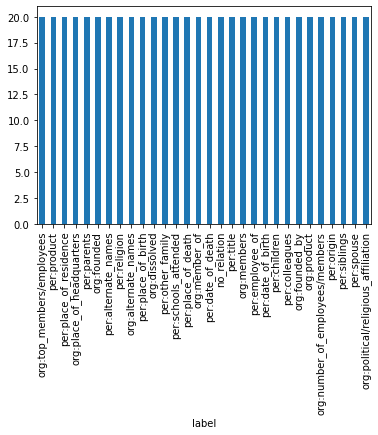

In [72]:
compare['label'].value_counts().plot(kind='bar')

In [49]:
def klue_re_micro_f1(preds, labels):
    """KLUE-RE micro f1 (except no_relation)"""
    label_list = ['no_relation', 'org:top_members/employees', 'org:members',
       'org:product', 'per:title', 'org:alternate_names',
       'per:employee_of', 'org:place_of_headquarters', 'per:product',
       'org:number_of_employees/members', 'per:children',
       'per:place_of_residence', 'per:alternate_names',
       'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings',
       'per:spouse', 'org:founded', 'org:political/religious_affiliation',
       'org:member_of', 'per:parents', 'org:dissolved',
       'per:schools_attended', 'per:date_of_death', 'per:date_of_birth',
       'per:place_of_birth', 'per:place_of_death', 'org:founded_by',
       'per:religion']
    no_relation_label_idx = label_list.index("no_relation")
    preds = label_to_num(preds.values)
    labels = label_to_num(labels.values)

    label_indices = list(range(len(label_list)))
    # label_indices.remove(no_relation_label_idx)
    return sklearn.metrics.f1_score(labels, preds, average="micro", labels=label_indices) * 100.0


def label_to_num(label):
  num_label = []
  with open('../code/dict_label_to_num.pkl', 'rb') as f:
    dict_label_to_num = pickle.load(f)
  for v in label:
    num_label.append(dict_label_to_num[v])
  
  return num_label

In [55]:
compare = pd.concat([labels[['id','label']],pred.pred_label],axis=1)
compare.head()
print((klue_re_micro_f1(compare.pred_label,compare.label)))

83.16666666666667


In [54]:
compare = pd.concat([labels[['id','label']],pred.pred_label],axis=1)
compare=compare[compare.label != 'no_relation']
print((klue_re_micro_f1(compare.pred_label,compare.label)))


83.79310344827586


In [53]:
compare = pd.concat([labels[['id','label']],pred.pred_label],axis=1)
compare=compare[compare.pred_label != 'no_relation']
print((klue_re_micro_f1(compare.pred_label,compare.label)))


85.86572438162544


In [104]:
def whatType(string):
    dic = eval(string)
    return dic['type']

In [111]:
test_data= pd.read_csv('../data/dataset/test/test_data.csv')
test_data['object_type'] = test_data['object_entity'].apply(lambda x: whatType(x))
test_data['subject_type'] = test_data['subject_entity'].apply(lambda x: whatType(x))

In [112]:
result = pd.read_csv('../code/prediction/train_half_arg.csv')
result['object_type']= test_data['object_type']
result['subject_type']= test_data['subject_type']
# result['pred_label'].value_counts().plot(kind='bar')
result.head()

,id,pred_label,probs,object_type,subject_type
0,0,org:alternate_names,"[0.02041192166507244, 0.005389280617237091, 0....",ORG,ORG
1,1,per:alternate_names,"[3.6237604945199564e-05, 2.641566788952332e-05...",POH,PER
2,2,no_relation,"[0.998301088809967, 3.030454354302492e-05, 7.6...",DAT,ORG
3,3,no_relation,"[0.7988805174827576, 0.00030542942113243043, 0...",PER,PER
4,4,no_relation,"[0.7109772562980652, 0.23348800837993622, 0.00...",PER,ORG


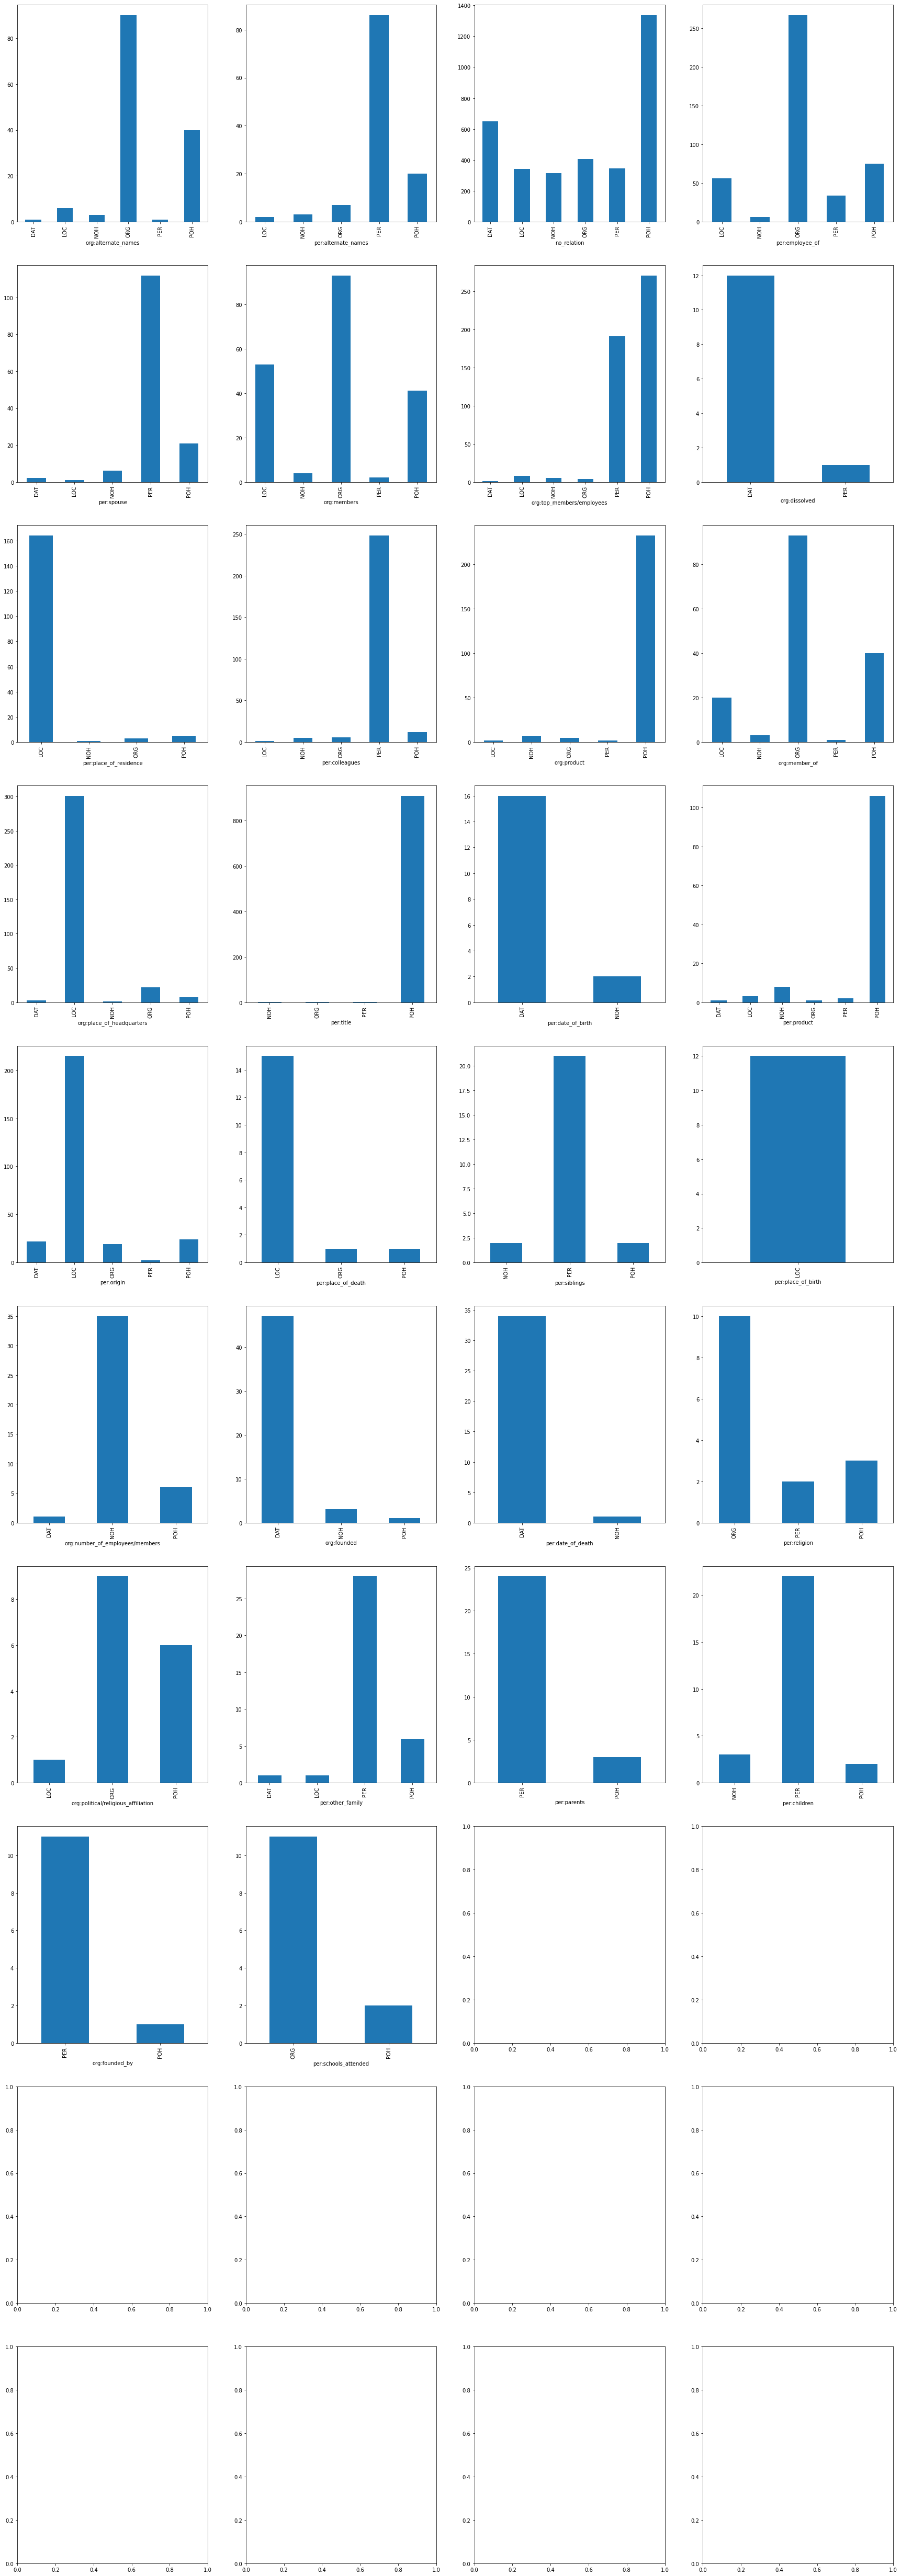

In [140]:
fig, axes = plt.subplots(10, 4, figsize=(30, 90))
axes= axes.flatten()

for num, label in enumerate(result.pred_label.unique()):
    result[result.pred_label == label].groupby(['object_type']).count().id.plot(kind='bar',ax=axes[num])
    axes[num].set_xlabel(label)

In [131]:
result.pred_label.unique()[0]

'org:alternate_names'

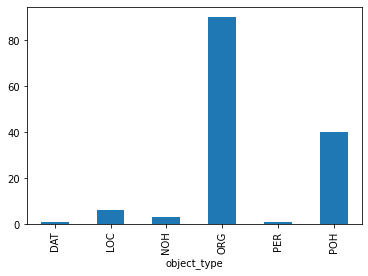

In [133]:
for num, label in enumerate(result.pred_label.unique()[:1]):
    result[result.pred_label == label].groupby(['object_type']).count().id.plot(kind='bar')

In [118]:
result.pred_label.unique()

array(['org:alternate_names', 'per:alternate_names', 'no_relation',
       'per:employee_of', 'per:spouse', 'org:members',
       'org:top_members/employees', 'org:dissolved',
       'per:place_of_residence', 'per:colleagues', 'org:product',
       'org:member_of', 'org:place_of_headquarters', 'per:title',
       'per:date_of_birth', 'per:product', 'per:origin',
       'per:place_of_death', 'per:siblings', 'per:place_of_birth',
       'org:number_of_employees/members', 'org:founded',
       'per:date_of_death', 'per:religion',
       'org:political/religious_affiliation', 'per:other_family',
       'per:parents', 'per:children', 'org:founded_by',
       'per:schools_attended'], dtype=object)